In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
DEFAULT_VALUE = np.nan

In [2]:
# loading data
data = pd.read_csv('./train.csv')

# Data Pretreatment

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
data['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [5]:
#find is there null value
data.isnull().sum()[lambda x: x>0]

Age         177
Cabin       687
Embarked      2
dtype: int64

In [6]:
#simplify 'Cabin' columns
data['Cabin'] = data['Cabin'].fillna('Standing')
#Accroding to the blueprint of titanic, there is no 'T' class cabin. 
#And there is only 1 person of 'T' class, so we change it to 'E' class accroding to his ticket price.
data['Cabin'].loc[data['Cabin']=='T']='E'
data['Cabin'] = data['Cabin'].apply(lambda X: X[0])

In [7]:
#fill null values in 'Embarked' with mode
data['Embarked']=data['Embarked'].fillna(data['Embarked'].value_counts().index[0])

# Feature Engineering

In [8]:
#make full use of 'Name' columns
data['Name'] = data['Name'].apply(lambda X: X.split(',')[1].split('.')[0].strip())
data['Name'].value_counts()
data['Name'] = data['Name'].apply(lambda X: 'Other' if X not in ['Mr','Miss','Mrs','Master'] else X)
group=data.groupby(['Name'])
medianofage=group['Age'].median()
medianofage

Name
Master     3.5
Miss      21.0
Mr        30.0
Mrs       35.0
Other     44.5
Name: Age, dtype: float64

In [9]:
#fill null values in 'age' based on name
def fillage (cols):
    age=cols[0]
    title=cols[1]
    if pd.isnull(age):
        return medianofage[title]
    return age

data['Age']=data[['Age','Name']].apply(fillage,axis=1)

In [10]:
#integrate similar columns
data['FamilySize'] = data['Parch'] + data['SibSp'] + 1
data=data.drop(columns=['Parch','SibSp'])

In [11]:
data[:5]

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,FamilySize
0,1,0,3,Mr,male,22.0,A/5 21171,7.2500,S,S,2
1,2,1,1,Mrs,female,38.0,PC 17599,71.2833,C,C,2
2,3,1,3,Miss,female,26.0,STON/O2. 3101282,7.9250,S,S,1
3,4,1,1,Mrs,female,35.0,113803,53.1000,C,S,2
4,5,0,3,Mr,male,35.0,373450,8.0500,S,S,1


In [12]:
#transform column 'sex' to boolean type
data['Sex'] = data['Sex'].apply(lambda X: 0 if X == 'male' else 1)

In [13]:
#Dummy
data = pd.get_dummies(data, columns=['Embarked','Name','Cabin'])

In [14]:
#get rid of unwanted columns
data=data.drop(columns=['PassengerId','Ticket'])

In [15]:
data[:5]

,Survived,Pclass,Sex,Age,Fare,FamilySize,Embarked_C,Embarked_Q,Embarked_S,Name_Master,...,Name_Mrs,Name_Other,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_S
0,0,3,0,22.0,7.2500,2,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1,1,1,38.0,71.2833,2,1,0,0,0,...,1,0,0,0,1,0,0,0,0,0
2,1,3,1,26.0,7.9250,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,1,1,1,35.0,53.1000,2,0,0,1,0,...,1,0,0,0,1,0,0,0,0,0
4,0,3,0,35.0,8.0500,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


# Data Splite 

In [16]:
from sklearn import model_selection
# get the name of independent values
predictors = data.columns[1:]
predictors

Index(['Pclass', 'Sex', 'Age', 'Fare', 'FamilySize', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'Name_Master', 'Name_Miss', 'Name_Mr',
       'Name_Mrs', 'Name_Other', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D',
       'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_S'],
      dtype='object')

In [20]:
#split the data
X_train, X_test, y_train, y_test = model_selection.train_test_split(data[predictors], data['Survived'], 
                                                                    test_size = 0.33, random_state = 1234)

In [21]:
len(X_test)

295

# Naive Bayes as Baseline

In [24]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report

#model
NB = BernoulliNB()
NB.fit(X_train, y_train)

#get scores
print('\nClassification report of Naive bayes:\n')
print(classification_report(y_test, NB.predict(X_test)))


Classification report of Naive bayes:

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       183
           1       0.77      0.77      0.77       112

    accuracy                           0.82       295
   macro avg       0.81      0.81      0.81       295
weighted avg       0.82      0.82      0.82       295



# Decision Tree

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn import metrics
# preset the choosed parameters
max_depth = [2,3,4,5,6,7,8]
min_samples_split = [2,4,6,8]
min_samples_leaf = [2,4,8,10,12]
DT_parameters = {'max_depth':max_depth, 'min_samples_split':min_samples_split, 'min_samples_leaf':min_samples_leaf}
DT_parameters

{'max_depth': [2, 3, 4, 5, 6, 7, 8],
 'min_samples_split': [2, 4, 6, 8],
 'min_samples_leaf': [2, 4, 8, 10, 12]}

In [26]:
from sklearn.metrics import classification_report
# Gridsearch to find the best parameters
DT_Model = GridSearchCV(estimator = tree.DecisionTreeClassifier(), param_grid = DT_parameters, cv=10)
# model fit
DT_Model.fit(X_train, y_train)
# Print best params
print('\nBest parameters:', DT_Model.best_params_)

print('\nClassification report of decision tree:\n')
print(classification_report(y_test, DT_Model.predict(X_test)))


Best parameters: {'max_depth': 7, 'min_samples_leaf': 8, 'min_samples_split': 4}

Classification report of decision tree:

              precision    recall  f1-score   support

           0       0.84      0.89      0.86       183
           1       0.80      0.71      0.75       112

    accuracy                           0.82       295
   macro avg       0.82      0.80      0.81       295
weighted avg       0.82      0.82      0.82       295



D:\MDS\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [56]:
params = {'max_depth': 7, 'min_samples_leaf': 8, 'min_samples_split': 4, 'random_state': 1234}
DT = tree.DecisionTreeClassifier(**params)
DT.fit(X_train, y_train)
DT_pred = DT.predict(X_test)
DT_accuracy = metrics.accuracy_score(y_test, DT_pred)
print('The accuracy on test：\n',DT_accuracy)

The accuracy on test：
 0.8372881355932204


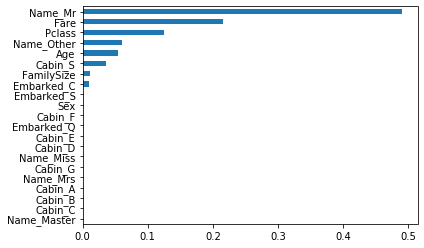

In [76]:
Impt_Series = pd.Series(DT.feature_importances_, index = X_train.columns)
Impt_Series.sort_values(ascending = True).plot('barh')
plt.show()

# Random Forest

In [32]:
# preset the paramiter
from sklearn.ensemble import RandomForestClassifier
RF_parameters = {
    'n_estimators': [50, 70, 100, 200],
    'max_depth':  [2,3,4,5,6,7],
    'min_samples_split' : [2,4,6,8],
    'min_samples_leaf' : [2,4,8,10,12],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [33]:
#use grid search do 10 times cross validation
RF_Model = GridSearchCV(estimator = RandomForestClassifier(), param_grid = RF_parameters, cv=10)
# model fit
RF_Model.fit(X_train, y_train)
# Print best params
print('\nBest parameters:', RF_Model.best_params_)


Best parameters: {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 100}


D:\MDS\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [57]:
params = {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 100, 'random_state':88}
RF = RandomForestClassifier(**params)
RF.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=7, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=88, verbose=0,
                       warm_start=False)

In [58]:
RF_pred = RF.predict(X_test)

print('\nClassification report of decision tree:\n')
print(classification_report(y_test, RF_pred))

RF_accuracy = metrics.accuracy_score(y_test, RF_pred)
print('The accuracy on test：\n',RF_accuracy)


Classification report of decision tree:

              precision    recall  f1-score   support

           0       0.85      0.93      0.89       183
           1       0.86      0.72      0.79       112

    accuracy                           0.85       295
   macro avg       0.85      0.83      0.84       295
weighted avg       0.85      0.85      0.85       295

The accuracy on test：
 0.8508474576271187


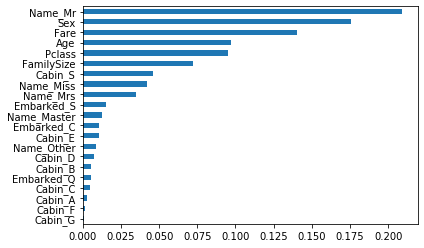

In [60]:
# get the feature importances
RF_Model = RandomForestClassifier(**params)
RF_Model.fit(X_train, y_train)
importance = RF_Model.feature_importances_
Impt_Series = pd.Series(importance, index = X_train.columns)
Impt_Series.sort_values(ascending = True).plot('barh')
plt.show()

# Logistic Regression

In [45]:
from sklearn.linear_model import LogisticRegression
LG_parameters = {
    'C': [1, 5, 10, 100, 1000, 1e4, ], 
    'penalty': ['l1', 'l2']
}
#search model
LG_model = GridSearchCV(LogisticRegression(), LG_parameters, cv=10)
LG_model.fit(X_train, y_train)

# Print best params
print('\nBest parameters:', LG_model.best_params_)


Best parameters: {'C': 1, 'penalty': 'l1'}


In [79]:
params = {'C': 1, 'penalty': 'l1','random_state':88}
LG = LogisticRegression(**params)
LG.fit(X_train,y_train)

LG_pred =  LG_model.predict(X_test)
print('\nClassification report of logistic regression:\n')
print(classification_report(y_test, LG_model.predict(X_test)))

LG_accuracy = metrics.accuracy_score(y_test, LG_pred)
print('The accuracy on test：\n',LG_accuracy)


Classification report of logistic regression:

              precision    recall  f1-score   support

           0       0.87      0.90      0.88       183
           1       0.82      0.79      0.80       112

    accuracy                           0.85       295
   macro avg       0.85      0.84      0.84       295
weighted avg       0.85      0.85      0.85       295

The accuracy on test：
 0.8542372881355932


# Ensemble

In [64]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

#votingclassifier to ensemble mode
vote_clf = VotingClassifier(estimators=[('lr', LG), ('rf', RF), ('dt', DT), ('gnb', NB)], voting='soft', weights = [2,5,1,1])
vote_clf.fit(X_train,y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l1',
                                                 random_state=None,
                                                 solver='warn', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gini',
                                             

In [65]:
#predict value
vote_pred = vote_clf.predict(X_test)
#get the accuracy and F1-score results of voting classifer
print('\nClassification report of voting classifier:\n')
print(classification_report(y_test, vote_pred))


Classification report of voting classifier:

              precision    recall  f1-score   support

           0       0.87      0.90      0.89       183
           1       0.83      0.79      0.81       112

    accuracy                           0.86       295
   macro avg       0.85      0.84      0.85       295
weighted avg       0.86      0.86      0.86       295



In [66]:
for clf in (LG,RF,DT,NB,vote_clf):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_pred,y_test)
    print(clf.__class__.__name__,score)

LogisticRegression 0.8542372881355932
RandomForestClassifier 0.8508474576271187
DecisionTreeClassifier 0.8372881355932204
BernoulliNB 0.823728813559322
VotingClassifier 0.8576271186440678


# ROC and AUC

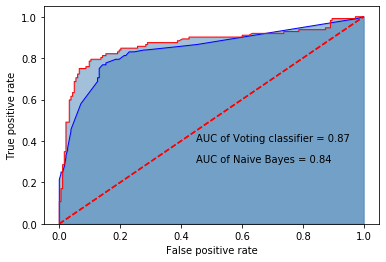

In [67]:
#prepare array
edge_colors = ['blue', 'red']
names = ['Naive Bayes', 'Voting classifier']
#show ROC of each model
for i, clf in enumerate([NB, vote_clf]):
    y_score = clf.predict_proba(X_test)[:,1]
    fpr,tpr,threshold = metrics.roc_curve(y_test, y_score)
    roc_auc = metrics.auc(fpr,tpr)
    plt.stackplot(fpr, tpr, color='steelblue', alpha = 0.5, edgecolor = 'black')
    plt.plot(fpr, tpr, color= edge_colors[i], lw = 1)
    plt.plot([0,1],[0,1], color = 'red', linestyle = '--')
    plt.text(0.45 ,0.1*i+0.3,'AUC of '+ names[i] +  ' = %0.2f' % roc_auc)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

# McNemar's test

In [68]:
from scipy.stats import chi2

def mcnemar(x, y):
    n1 = np.sum(x < y)
    n2 = np.sum(x > y)
    stat = (np.abs(n1-n2)-1)**2 / (n1+n2)
    df = 1
    pval = chi2.sf(stat,1)
    return stat, pval

In [75]:
NB_yn = np.array([int(p==t) for p,t in zip(NB.predict(X_test), y_test)])
vote_yn = np.array([int(p==t) for p,t in zip(vote_clf.predict(X_test), y_test)])
# There's very little difference in this data set
print('Prediction of Naive Bayes model(baseline)\n',NB_yn)
print('Prediction of Ensemble model of (RF,LG,DT)\n',vote_yn)
# We reject H0. 
# Therefore, we can select voting classifier,
print('\nCan we reject H0?\n'+'Yes, we have sufficent evidence for the p-value is: ' if mcnemar(NB_yn, vote_yn)[1]<0.05 else 'No, we have insufficent evidence for the p-value is = ' ,mcnemar(NB_yn, vote_yn)[1])

Prediction of Naive Bayes model(baseline)
 [1 1 1 1 1 0 1 0 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 0 1 1
 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 0 1 0 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1
 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 1 0]
Prediction of Ensemble model of (RF,LG,DT)
 [1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 0 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 0 1 1